In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import os
from torch.utils.data import Dataset, DataLoader
import datetime
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm
# 常数定义
E = 210e9       # 杨氏模量 (Pa)
v = 0.3         # 泊松比
T = 0.03        # 厚度 (m)
H = 0.03        # 高度 (m)
L = 1.0         # 梁长 (m)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [2]:
test_x = np.linspace(0.02, 0.92, 10).reshape(-1, 1)

# 高斯过程参数
sigma = 1.0       # 方差幅度
length_scale = 0.2   # 平滑程度（越大越平滑）
kernel = sigma**2 * RBF(length_scale=length_scale)

gp = GaussianProcessRegressor(kernel=kernel)

n_samples = 1000
all_F = []
for i in tqdm(range(n_samples), desc="Generating GRF samples"):
    F_y_sample = gp.sample_y(test_x, n_samples=1, random_state=np.random.randint(0, 1e6))
    F_y_sample = F_y_sample / np.max(np.abs(F_y_sample)) * 2e-4
    all_F.append(F_y_sample.ravel())
    
all_F = np.array(all_F)
print('Scale: ',all_F.min(),' ~ ',all_F.max())
print('Shape: ', all_F.shape)

Generating GRF samples: 100%|████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2100.12it/s]

Scale:  -0.0002  ~  0.0002


(1000, 10)

In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=100, depth=3):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers.append(nn.Linear(hidden, out_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
        
class Modified_MLP_Block(nn.Module):
    def __init__(self, input_dim, hidden_channel, output_dim, hidden_size=4):
        super(Modified_MLP_Block, self).__init__()
        self.activation = nn.Tanh()
        self.encodeU = nn.Linear(input_dim, hidden_channel)
        self.encodeV = nn.Linear(input_dim, hidden_channel)
        self.In = nn.Linear(input_dim, hidden_channel)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_channel, hidden_channel) for _ in range(hidden_size)
        ])
        self.out = nn.Linear(hidden_channel, output_dim)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.constant_(m.bias, 0.0)
                
    def forward(self, x):
        U = self.activation(self.encodeU(x))
        V = self.activation(self.encodeV(x))
        H = self.activation(self.In(x))

        for layer in self.hidden_layers:
            Z = self.activation(layer(H))
            H = (1 - Z) * U + Z * V

        x = self.out(H)
        return x
        
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden=100):
        super(DeepONet, self).__init__()
        self.branch_net = Modified_MLP_Block(branch_input_dim, hidden, hidden, hidden_size=3)
        self.trunk_net = Modified_MLP_Block(trunk_input_dim, hidden, hidden, hidden_size=3)

    def forward(self, f, x):
        B = self.branch_net(f)         # [batch, hidden]
        T = self.trunk_net(x)          # [batch, hidden]
        return (torch.sum(B * T, dim=-1, keepdim=True)) * x

In [4]:
x = np.linspace(0.02, 0.92, 10).reshape(-1, 1)
X_train = np.zeros((1000 * 10, 11))
for i in range(1000):
    current_F = all_F[i, :]
    repeated_F = np.tile(current_F, (10, 1))
    paired_data = np.hstack([repeated_F, x])
    start_idx = i * 10
    end_idx = (i + 1) * 10
    X_train[start_idx:end_idx, :] = paired_data

class Dataset(Dataset):
    def __init__(self, data, device  ='cuda', length = 10000):
        self.data = data
        self.device = device
        
    def __getitem__(self, index):
        B_data = self.data[index][:-1]
        T_data = self.data[index][-1:]
        B_data = torch.tensor(B_data, dtype=torch.float32, requires_grad=True)
        T_data = torch.tensor(T_data, dtype=torch.float32, requires_grad=True)
        return B_data, T_data
        
    def __len__(self):
        return len(self.data)
        
Train_Dataset = Dataset(X_train, device = device)
Train_DataLoader = DataLoader(Train_Dataset, batch_size=10000, shuffle=True)

In [5]:
def get_pde_loss(model, f, x):
    w = model(f, x)
    dw_dx = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True)[0]
    d2w_dx2 = torch.autograd.grad(dw_dx, x, grad_outputs=torch.ones_like(dw_dx), create_graph=True)[0]
    index = ((x - 0.02) / 0.1).cpu().detach().numpy().round()
    index = index.flatten()
    row_indices = torch.arange(f.size(0))
    eps_x = f[row_indices,index].reshape(-1,1)
    pde_residual = eps_x + 0.5 * T * d2w_dx2
    return torch.mean(pde_residual ** 2)
    
def get_bc_loss(model, f):
    b, _ = f.shape
    x0 = torch.zeros([b,1]).to(device)
    x0.requires_grad_(True)
    w0 = model(f, x0)
    dw_dx0 = torch.autograd.grad(w0, x0, grad_outputs=torch.ones_like(w0), create_graph=True)[0]
    return torch.mean(w0 ** 2) + torch.mean(dw_dx0 ** 2)

Epoch 0: PDE=1.4636e-08 | BC=0.0000e+00
Epoch 200: PDE=9.9093e-09 | BC=5.3982e-11
Epoch 400: PDE=5.6532e-09 | BC=1.9815e-11
Epoch 600: PDE=5.0507e-09 | BC=1.7629e-11
Epoch 800: PDE=4.9572e-09 | BC=1.7103e-11
Epoch 1000: PDE=4.8043e-09 | BC=1.5647e-11
Epoch 1200: PDE=4.3315e-09 | BC=1.9313e-11
Epoch 1400: PDE=3.0328e-09 | BC=1.2567e-10
Epoch 1600: PDE=2.4214e-09 | BC=5.2128e-12
Epoch 1800: PDE=2.3143e-09 | BC=7.3767e-12
Training Time:  1311.592645 s
Current learning rate: 7.69449752767131e-05


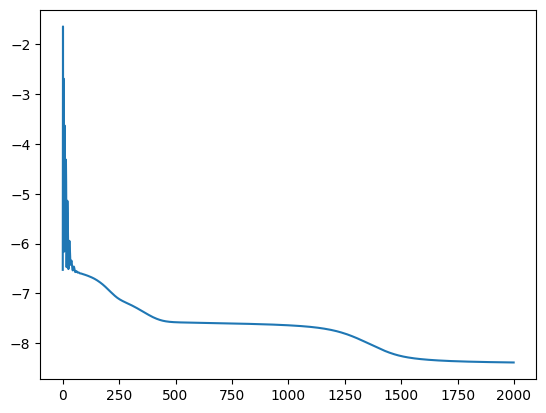

In [6]:
model = DeepONet(10,1,200).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.95)
epochs = 2000
start_time = datetime.datetime.now()
Loss = []
for epoch in range(epochs):
    epoch_pde_loss = 0
    epoch_bc_loss = 0
    for i, (B_data, T_data) in enumerate(Train_DataLoader):
        B_data = B_data.to(device)
        T_data = T_data.to(device)
        optimizer.zero_grad()
        loss_pde = get_pde_loss(model, B_data, T_data)
        loss_bc = get_bc_loss(model, B_data)
        loss = loss_pde * 1e5 + loss_bc
        epoch_pde_loss += loss_pde.item()
        epoch_bc_loss += loss_bc.item()
        Loss.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: PDE={epoch_pde_loss:.4e} | BC={epoch_bc_loss:.4e}")
end_time = datetime.datetime.now()
running_time = end_time - start_time
print("Training Time: ", running_time.total_seconds(), "s")
print("Current learning rate:", optimizer.param_groups[0]['lr'])
plt.plot(np.log(Loss))
plt.show()

In [7]:
test_data = pd.read_csv(r'D:\DeepLearningDataset\Beam\Beam1d\beam.csv')
def Test(i):
    test_B_data = torch.tensor(np.repeat(np.array(test_data['exx'+str(i)]).reshape(1,-1),10,axis=0), dtype=torch.float32, requires_grad=True).to(device)
    test_T_data = torch.tensor(np.array(test_data['x']).reshape(-1,1), dtype=torch.float32, requires_grad=True).to(device)
    
    w_pre = model(test_B_data, test_T_data).cpu().detach().numpy().flatten()
    
    test_x = np.array(test_data['x'])
    w_ex = np.array(test_data['v'+str(i)])
    print(f'Error: {np.mean((w_pre - w_ex)**2)}')
    plt.plot(test_x, w_ex, label = 'True')
    plt.plot(test_x, w_pre, '*', ls='none', label = 'Pre')
    plt.legend()
    plt.show()

Error: 2.7620298985573232e-11


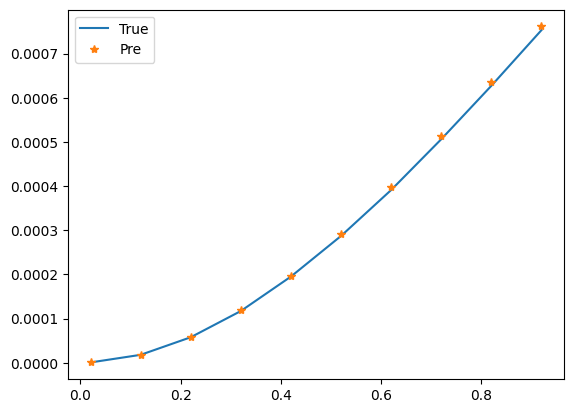

Error: 1.1140279142658357e-10


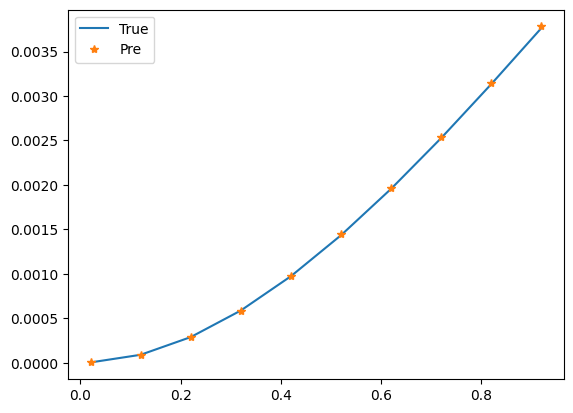

Error: 4.2851269780658345e-10


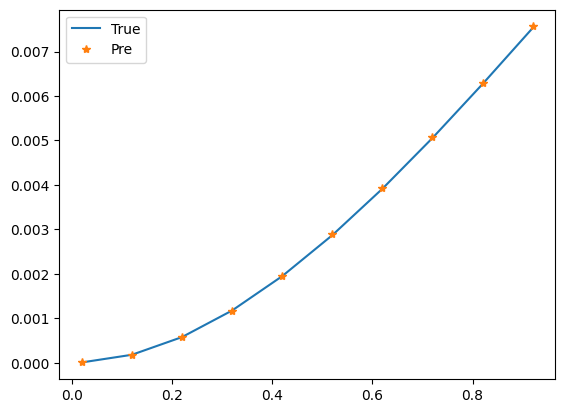

In [8]:
Test(1)
Test(5)
Test(10)

In [9]:
def Test(name):
    test_data = pd.read_csv('D:\DeepLearningDataset\Beam\\'+name+'.csv')
    test_B_data = torch.tensor(np.repeat(np.array(test_data['exx']).reshape(1,-1),10,axis=0), dtype=torch.float32, requires_grad=True).to(device)
    test_T_data = torch.tensor(np.array(test_data['x']).reshape(-1,1), dtype=torch.float32, requires_grad=True).to(device)
    
    w_pre = model(test_B_data, test_T_data).cpu().detach().numpy().flatten()
    
    test_x = np.array(test_data['x'])
    w_ex = np.array(test_data['v'])
    print(f'Error: {np.mean((w_pre - w_ex)**2)}')
    plt.plot(test_x, w_ex, label = 'True')
    plt.plot(test_x, w_pre, '*', ls='none', label = 'Pre')
    plt.legend()
    plt.show()

Error: 2.5359738961661304e-10


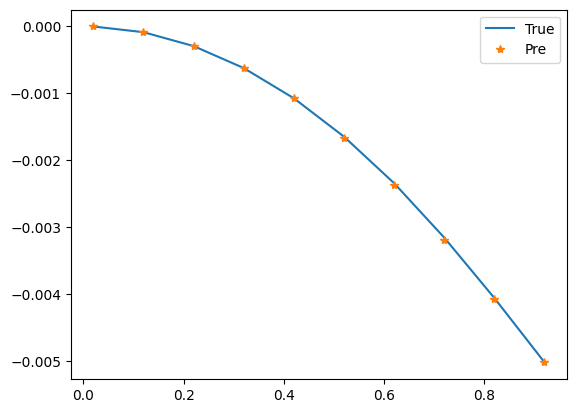

Error: 2.742647936177904e-10


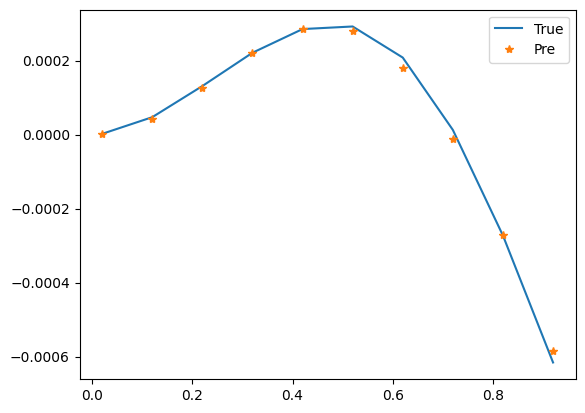

Error: 1.218222099433822e-09


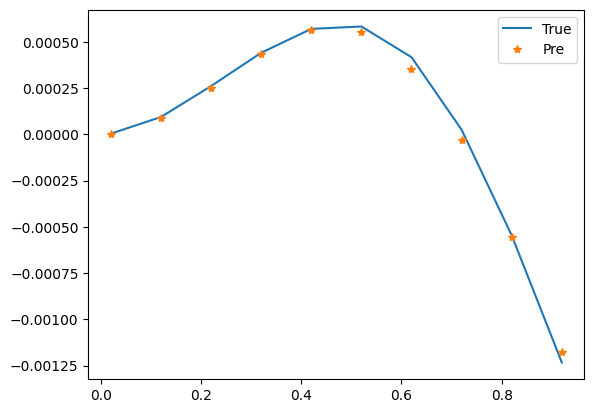

Error: 1.627125034202463e-09


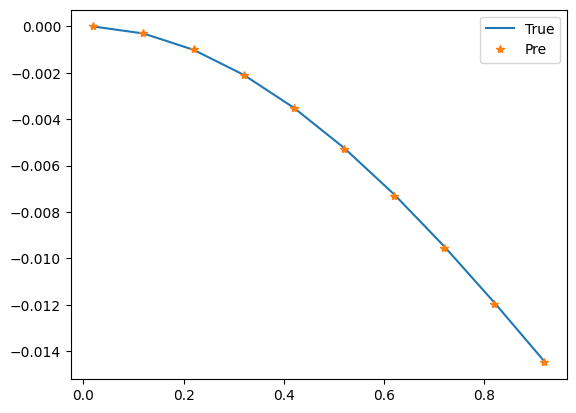

Error: 9.259648693806401e-11


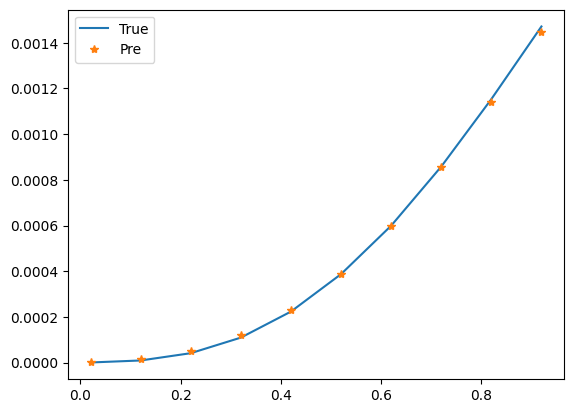

In [10]:
Test('beam1')
Test('beam2')
Test('beam3')
Test('beam4')
Test('beam5')